# Fast Gradient Method Attack and Binary Input Detector Using MNIST10

This notebook shows the Fast Gradient Method attack implmentation using the ART library against deep learning models trained on MNIST-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on CIFAR test data
* Implement FGSM attack using ART
* Create adversarial samples using the FGSM attack
* Evaluate the deep leaarning model against the adversaarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model

## Install and load required libraries 

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

2024-05-15 15:27:57.545162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 15:27:57.616735: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

### Load MNIST dataset

In [4]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = np.load('./../datasets/mnist10_dataset.npy', allow_pickle = True)
x_train, x_test = x_train / 255.0, x_test/ 255.0
min = x_train.min()
max = x_train.max()
x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 0.0, 1.0)

### Inspect the Data

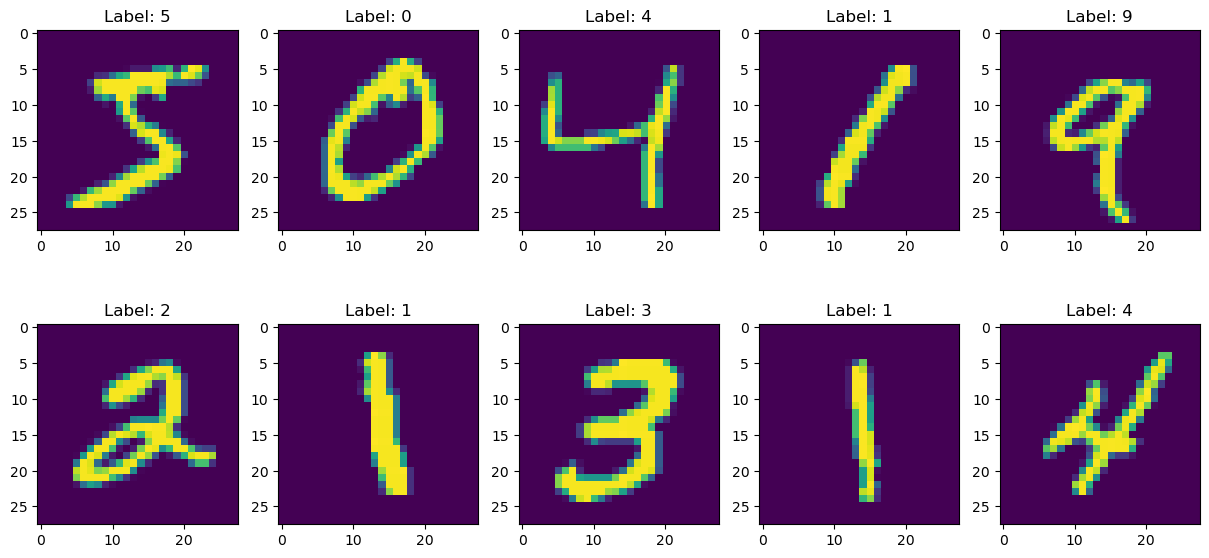

In [5]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {label}",  fontsize=12)

In [6]:
nb_classes =10
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)
x_test = np.expand_dims(x_test, axis=-1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
x_train = np.expand_dims(x_train, axis=-1)

## Creating the model using TensorFlow with Keras API

Create a model using Keras API. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics.

In [7]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
loss_ = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy']);

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

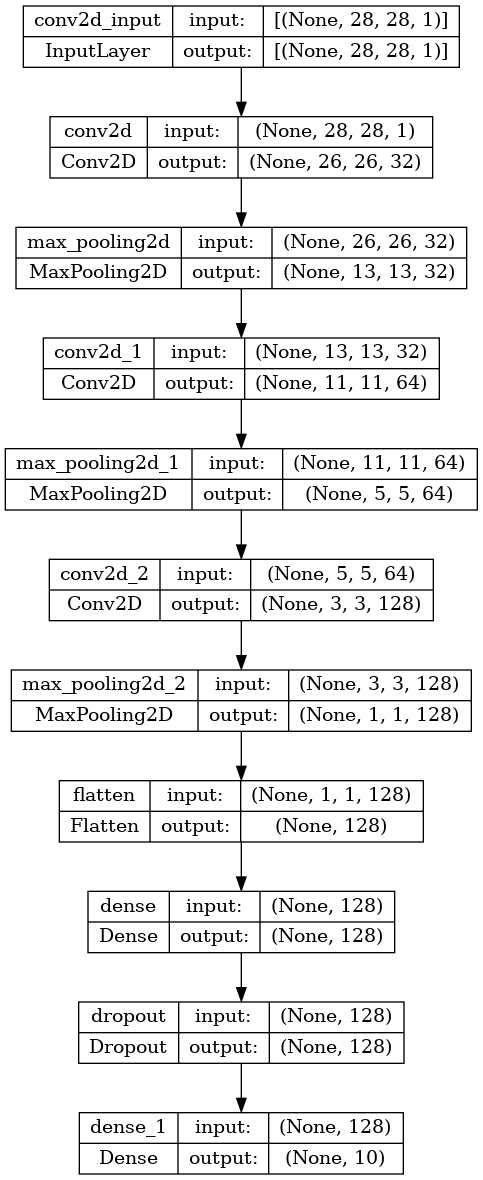

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Fit the model on training data.

In [ ]:
history = model.fit(x_train, y_train, epochs=3);

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.2060 - accuracy: 0.9369
Epoch 2/3
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.0734 - accuracy: 0.9773
Epoch 3/3
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.0522 - accuracy: 0.9843


In [10]:
# model.save('./../models/mnist10_conv.keras')
model = tf.keras.models.load_model('./../models/mnist10_conv.keras')
model.summary()

2024-05-15 15:29:43.535387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 15:29:43.765745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 638 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-05-15 15:29:43.766400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43916 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-05-15 15:29:43.785543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

2024-05-15 15:29:44.005176: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_1_1/bias/v/Assign' id:580 op device:{requested: '', assigned: ''} def:{{{node conv2d_1_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1_1/bias/v, conv2d_1_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Evaluate model accuracy on test data.

In [11]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-15 15:29:50.602662: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:478 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-15 15:29:50.692412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


Accuracy on test data: 98.57%


### Create a ART Keras classifier.

In [13]:
# after normalizing the data
min = 0
max = 1 # before normalizing, it was 255

classifier = KerasClassifier(model=model, clip_values=(min, max))

## Fast Gradient Method (FGM) (aka Fast Gradient Sign Method -- FGSM)
> class art.attacks.evasion.FastGradientMethod(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, minimal: bool = False, summary_writer: str | bool | SummaryWriter = False)

This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the “Fast Gradient Sign Method”). This implementation extends the attack to other norms, and is therefore called the Fast Gradient Method.
* Paper link: https://arxiv.org/abs/1412.6572

*\_\_init__(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, minimal: bool = False, summary_writer: str | bool | SummaryWriter = False) → None*

**Create a FastGradientMethod instance.**

     Parameters:
* estimator – A trained classifier.
* norm – The norm of the adversarial perturbation. Possible values: “inf”, np.inf, 1 or 2.
* eps – Attack step size (input variation).
* eps_step – Step size of input variation for minimal perturbation computation.
* targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False)
* num_random_init (int) – Number of random initialisations within the epsilon ball. For random_init=0 starting at the original input.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* minimal (bool) – Indicates if computing the minimal perturbation (True). If True, also define eps_step for the step size and eps for the maximum perturbation.
* summary_writer – Activate summary writer for TensorBoard. Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. If of type str save in path. If of type SummaryWriter apply provided custom summary writer. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**

Generate adversarial samples and return them in an array.

    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). Only provide this parameter if you’d like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the “label leaking” effect (explained in this paper: https://arxiv.org/abs/1611.01236). Default is None.

* mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations. Shape needs to be broadcastable to the shape of x and can also be of the same shape as x. Any features for which the mask is zero will not be adversarially perturbed.

        Returns:
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm


### Create an ART Fast Gradient Sign Method attack.

In [26]:
# eps – defines the attack step size (input variation). The smaller the eps, the little the attack scale would be.
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2)

### Generate adversarial test data.

In [27]:
x_test_adv = attack_fgsm.generate(x_test)

Visualise the first adversarial test sample.

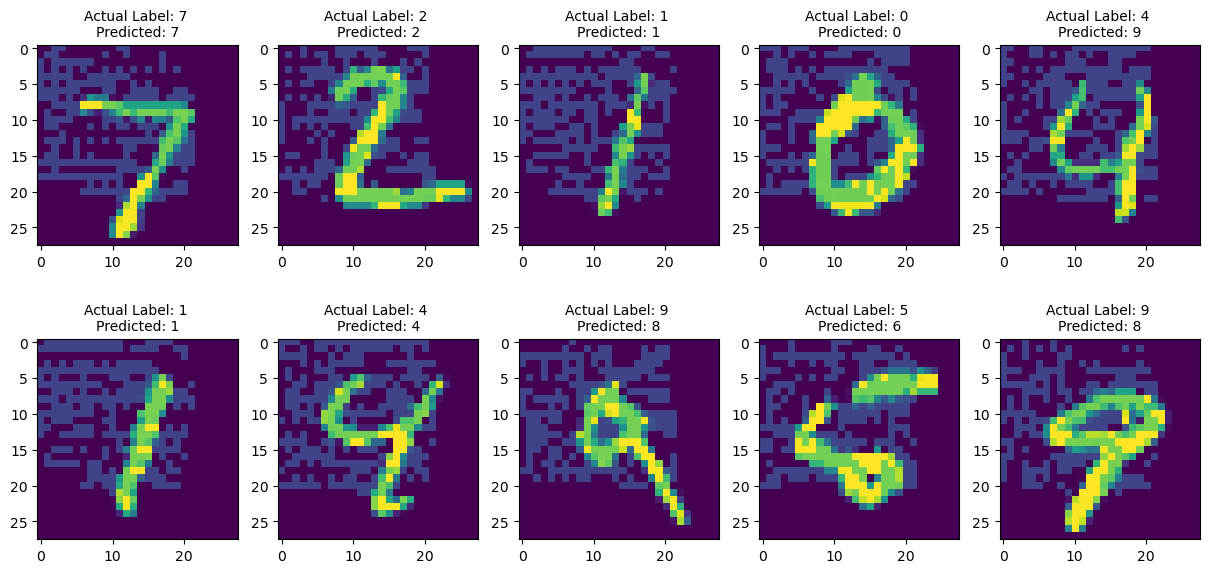

In [28]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label.argmax()} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=10)

Evaluate accuracy on adversarial test data and calculate average perturbation.

In [29]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 60.11%
Average perturbation: 0.07


##Training the detector

We create the second model using Keras API with the same strucure of the classifier. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics. This model will be used to classify between ordinary samples and perturbated ones

In [30]:
detector_model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
loss_ = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
detector_model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy']);

create samples of perturbaed using the attacker.

In [31]:
x_train_adv = attack_fgsm.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

2024-05-15 15:33:03.369527: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5/kernel/Assign' id:863 op device:{requested: '', assigned: ''} def:{{{node conv2d_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_5/kernel, conv2d_5/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [46]:
# np.savez('./fgsm_generated_data/fgsm_attach_generated_MNIST10_train.npz', 
#          x_train_detector=x_train_detector, y_train_detector = y_train_detector)

training_generated_data = np.load('./fgsm_generated_data/fgsm_attach_generated_MNIST10_train.npz')
x_train_detector, y_train_detector = training_generated_data['x_train_detector'], training_generated_data['y_train_detector']
x_train_detector.shape, y_train_detector.shape

((120000, 28, 28, 1), (120000, 2))

In [35]:
# detector_model.fit(x_train_detector, y_train_detector, epochs=3)

Train on 120000 samples
Epoch 1/3


2024-05-15 15:39:32.938883: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_2/mul' id:1010 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-15 15:39:32.983690: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/conv2d_3_1/kernel/m/Assign' id:1136 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_3_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_3_1/kernel/m, training/Adam/conv2d_3_1/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an err

120000/120000 [==============================] - 9s 71us/sample - loss: 0.0045 - accuracy: 0.9981
Epoch 2/3
120000/120000 [==============================] - 8s 67us/sample - loss: 5.8402e-04 - accuracy: 0.9999
Epoch 3/3
120000/120000 [==============================] - 8s 68us/sample - loss: 1.2497e-08 - accuracy: 1.0000


In [37]:
# detector_model.save('./../models/fsgm_mnist10_model.keras')
detector_model = tf.keras.models.load_model('./../models/fsgm_mnist10_model.keras')
detector_model.summary()

2024-05-15 15:41:19.517701: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3_1/kernel/Assign' id:1449 op device:{requested: '', assigned: ''} def:{{{node dense_3_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3_1/kernel, dense_3_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 128)       

2024-05-15 15:41:19.748732: W tensorflow/c/c_api.cc:291] Operation '{name:'beta_2_1/Assign' id:1591 op device:{requested: '', assigned: ''} def:{{{node beta_2_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta_2_1, beta_2_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### creating samples to test our detector model.

In [42]:
x_test = x_test[:100]
y_test = y_test[:100]

x_test_adv = attack_fgsm.generate(x_test)
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)

x_test_detector.shape, y_test_detector.shape

((200, 28, 28, 1), (200, 2))

### Evaluate detector model accuracy on combined test data.

In [43]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 100.00%


2024-05-15 15:42:59.367907: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_3/mul' id:1577 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [44]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [47]:
# detector.fit(x_train, y_train, batch_size = 128, nb_epochs= 5)
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

2024-05-15 15:44:31.936468: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_3/mul' id:1577 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Evaluating the detector

#### Apply the detector to the adversarial test data:

In [48]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 100
Not flagged: 0


2024-05-15 15:45:09.010005: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3_1/Softmax' id:1460 op device:{requested: '', assigned: ''} def:{{{node dense_3_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Apply the detector to the first 100 original test images:

In [49]:
_, is_adversarial = detector.detect(x_test[:100])
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 0
Not flagged: 100


### Evaluate the detector for different attack strengths eps (Note: for the training of detector, eps=0.25 was used)

In [50]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

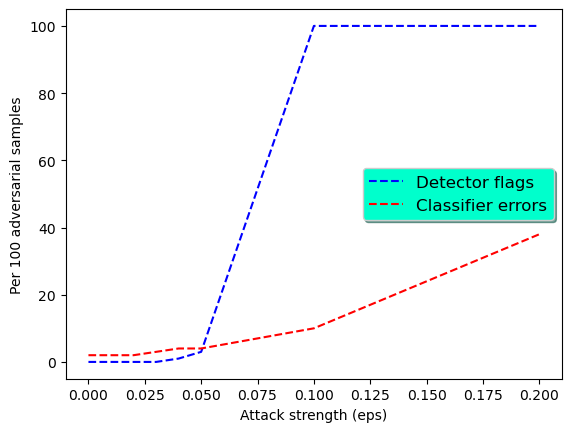

In [51]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

### Summary: 

The Fast Gradient Sign Method (FGSM) is an adversarial attack that perturbs input data to mislead machine learning models. It generates adversarial examples by adding a small, directed perturbation to each input, calculated using the gradient of the loss function with respect to the input. The perturbation is controlled by a parameter ϵϵ, which determines the magnitude of the change. Specifically, the perturbed input is given by x′=x+ϵ⋅sign(∇xJ(θ,x,y))x′=x+ϵ⋅sign(∇x​J(θ,x,y)). A larger ϵϵ increases the perturbation, making the attack more likely to succeed but potentially more noticeable.